# Анализ временных рядов: Seaborn flights

Будем предсказывать количество совершивших авиаперелёт пассажиров по данным из встроенного датасета библиотеки *Seaborn*.
Сначала решим задачу через эконометрический подход (построим **ARMA** модель), а затем создадим рекуррентную нейронную сеть и сравним **MAE** двух моделей.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sm
import statsmodels.api as smt
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Загружаем датасет.

In [2]:
data = sns.load_dataset('flights')
data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
data.tail()

,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


Количество пассажиров приведено помесячно с начала 1949 и по конец 1960 года. Выделим данные за последние 2 года в качестве тестового датасета.

In [4]:
ts_train = data.loc[data['year'] < 1959]['passengers']
ts_test = data.loc[data['year'] >= 1959]['passengers'].reset_index(drop=True)
full_ts = data['passengers']

Функция для отображения временного ряда, а также его АКФ, ЧАКФ и критерия Дики-Фуллера.

In [5]:
def plot_ts(ts, lags=None, style='bmh', show_stats=True):
    with plt.style.context(style):
        if show_stats:
            p = sm.tsa.stattools.adfuller(ts)[1]
            fig, (ts_plot, acf_plot, pacf_plot) = plt.subplots(3, 1, figsize=(18, 16))
            ts.plot(ax=ts_plot, xlabel='', title=f'Критерий Дики-Фуллера: p={p:.3f}', xticks=range(0, len(ts)+1, 12))
            smt.graphics.tsa.plot_acf(ts, ax=acf_plot, lags=lags, alpha=0.05, use_vlines=True,
                                      title='Автокорреляционная функция')
            smt.graphics.tsa.plot_pacf(ts, ax=pacf_plot, lags=lags, alpha=0.05, use_vlines=True,
                                       title='Частная автокорреляционная функция')
        else:
            ts.plot(figsize=(18, 10), xlabel='Месяцы', ylabel='Количество пассажиров', xticks=range(0, len(ts)+1, 12))
        plt.show()

Посмотрим на исходный ряд.

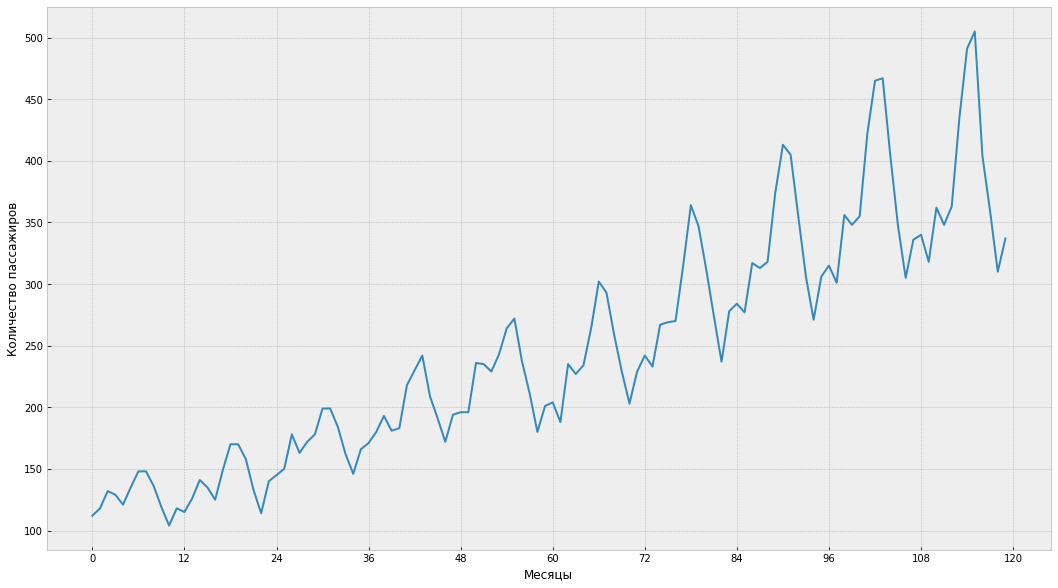

In [6]:
plot_ts(ts_train, show_stats=False)

Видим достаточно сильную гетероскедастичность, которую попробуем исправить преобразованием Бокса-Кокса.

In [7]:
ts_train_box, lmb = boxcox(ts_train)
ts_train_box = pd.Series(ts_train_box)
print(f'Оптимальное значение параметра λ: {lmb:.3f}')

Оптимальное значение параметра λ: 0.084


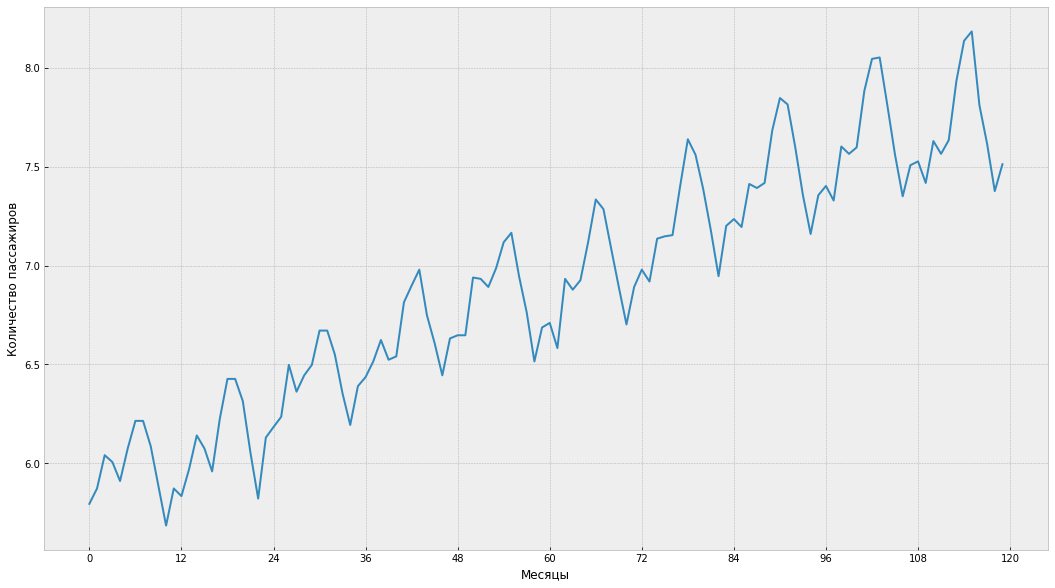

In [8]:
plot_ts(ts_train_box, show_stats=False)

Дисперсия стабилизировалась, теперь можно переходить к анализу АКФ и ЧАКФ ряда.

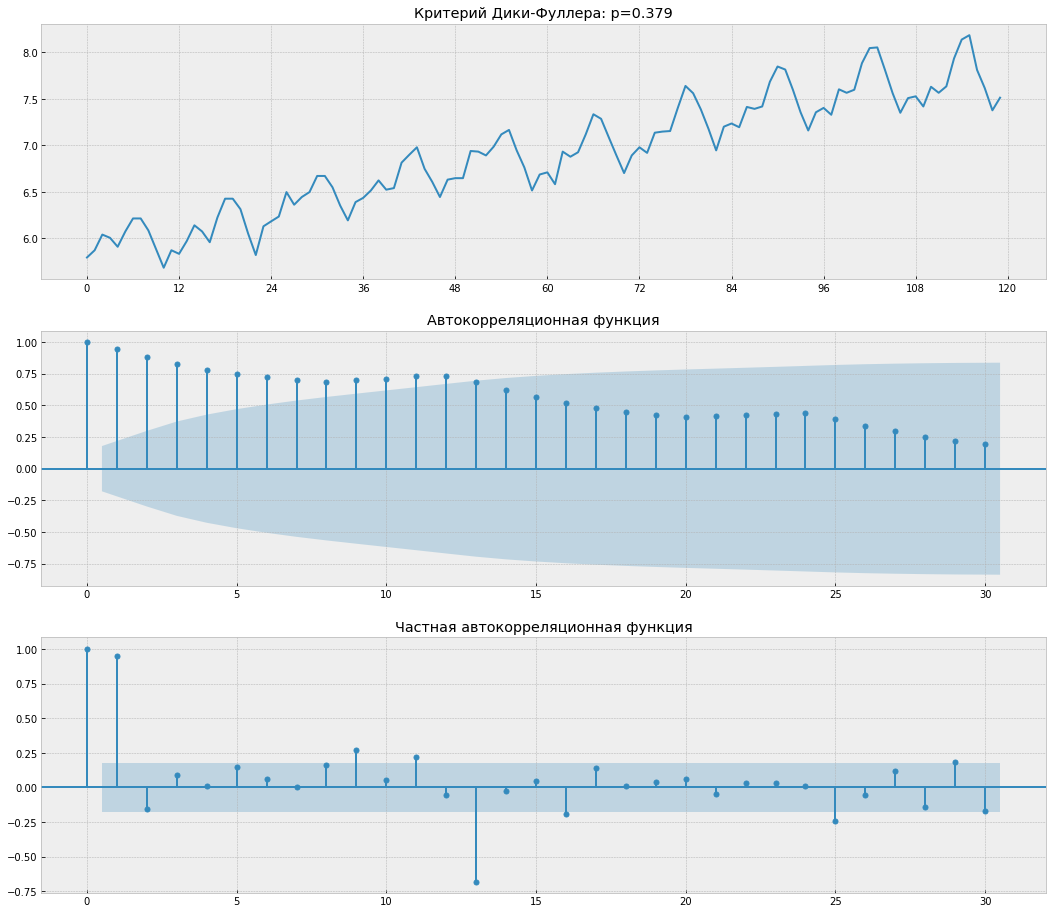

In [9]:
plot_ts(ts_train_box, lags=30)

В ряде присутствуют ярко выраженные тренд и сезонность. Сначала возьмём сезонные разности, которые составляют 12 месяцев.

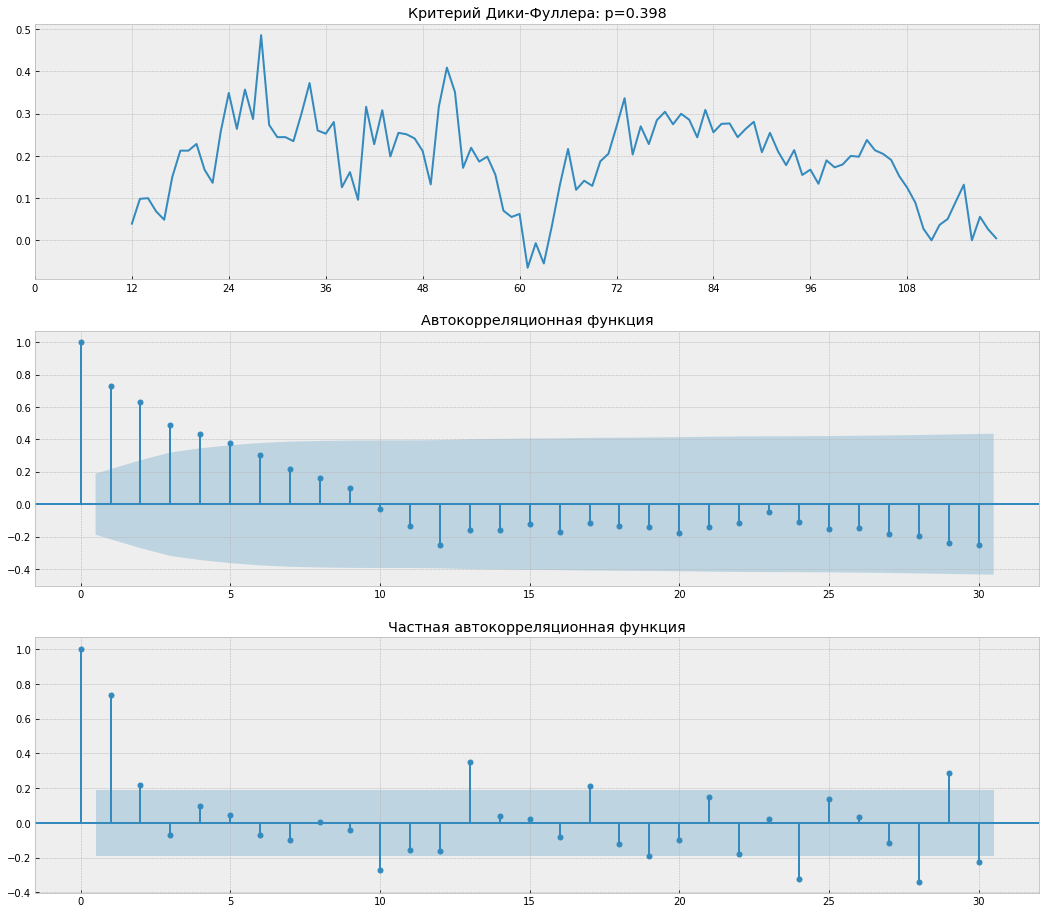

In [10]:
plot_ts(ts_train_box.diff(12).dropna(), lags=30)

На АКФ всё ещё присутствует большое количество значимых лагов, в то время как на ЧАКФ у нас из "больших" лагов только первый, поэтому возьмём ещё первые разности получившегося ряда.

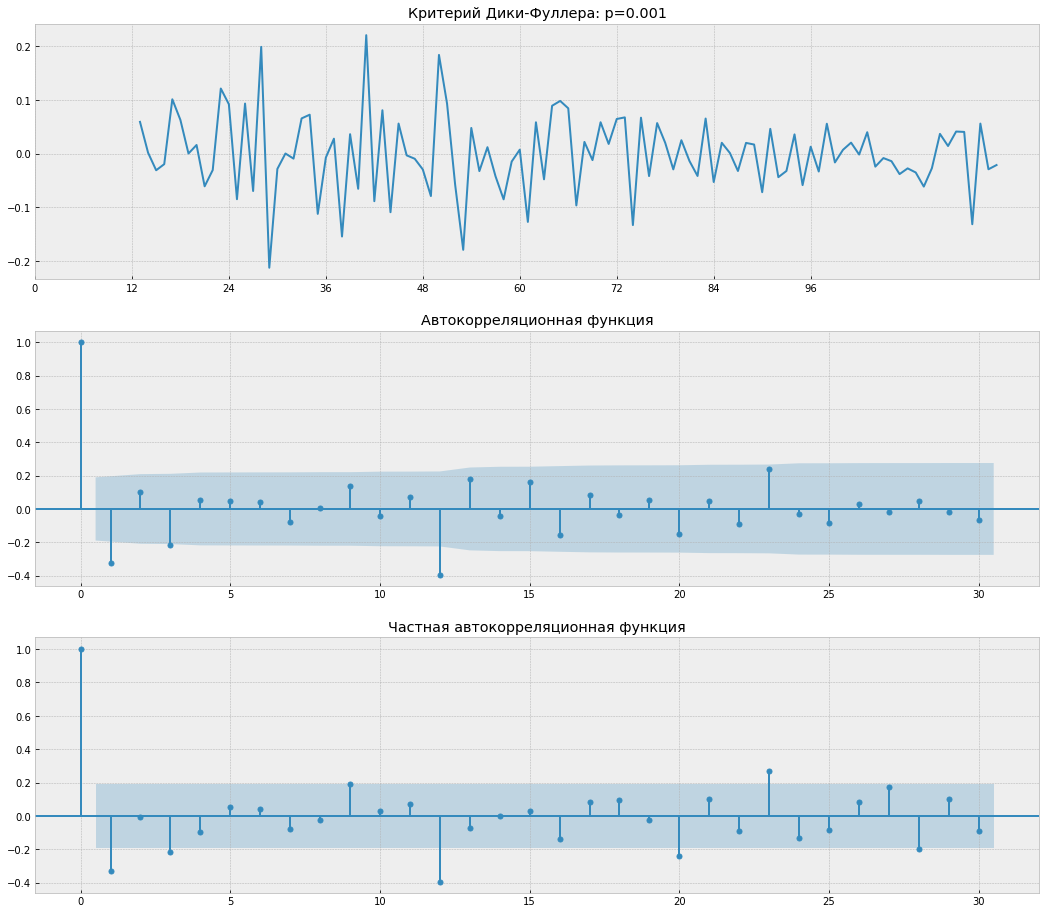

In [11]:
plot_ts((ts_train_box.diff(12).dropna()).diff().dropna(), lags=30)

Получили стационарный ряд без ярко выраженной структуры, можно переходить к построению модели:
- Порядок интеграции (**D**, **d**) - мы взяли сезонные и первые разности, поэтому параметры **D** и **d** равны 1;
- Порядок авторегрессионной (**AR**) составляющей (**P**, **p**) - его мы оцениваем по последним значимым лагам ЧАКФ: **P** и **p** равны 1;
- Порядок составляющей скользящего среднего (**MA**) (**Q**, **q**) - его мы оцениваем по последним значимым лагам АКФ: **Q** и **q** также равны 1.

Получаем модель *SARIMA(1, 1, 1) * (1, 1, 1)*.

In [12]:
model = sm.tsa.statespace.sarimax.SARIMAX(ts_train_box, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

Проведём анализ остатков модели.

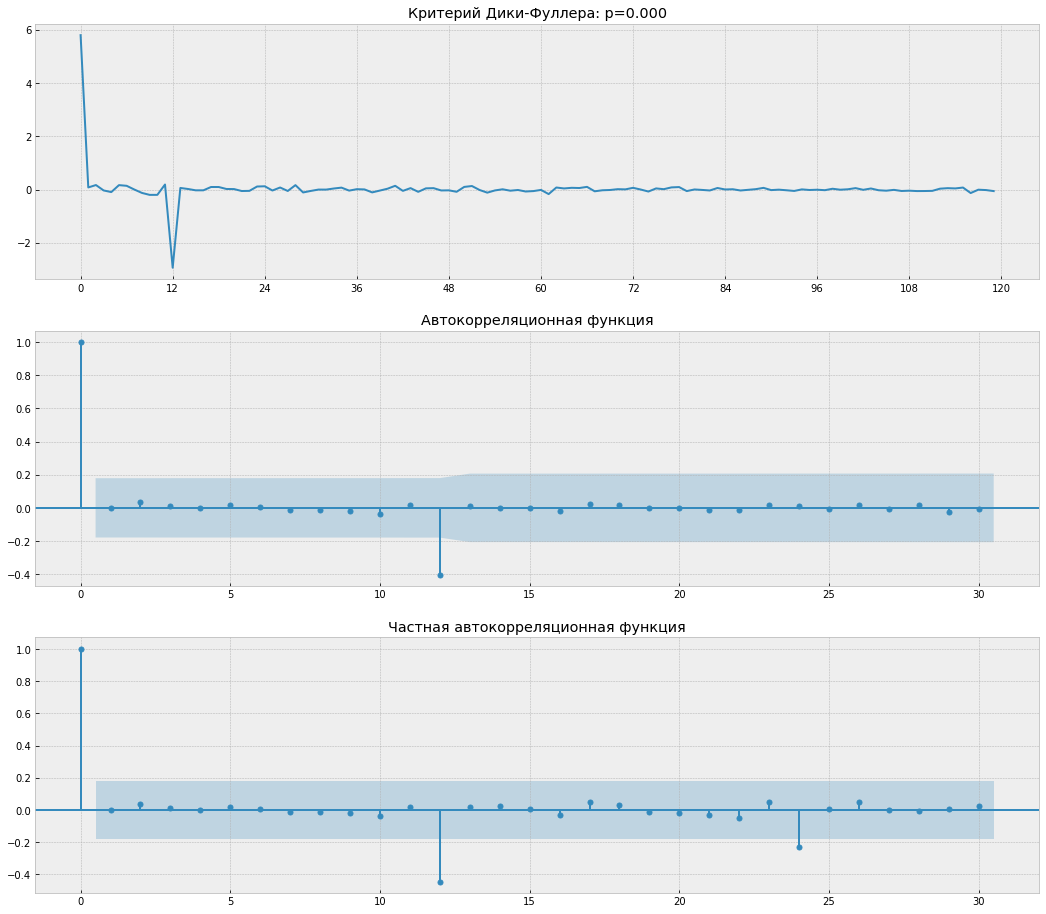

In [13]:
plot_ts(model.resid, lags=30)

Всё было бы идеально, если бы не странный огромный 12 лаг, который отобразится артефактом на графике прогноза, но во всём остальном модель очень даже хороша.

Функция для отрисовки исходного ряда и прогноза.

In [14]:
def plot_forecast(ts, forecast, ts_train, style='bmh'):
    with plt.style.context(style):
        plt.figure(figsize=(18, 10))
        plt.plot(range(len(ts)), ts, label='Ряд', c='b')
        plt.plot(range(len(forecast)), forecast, label='Прогноз', c='r')
        plt.axvspan(ts_train.index[-1], ts.index[-1], alpha=0.5, color='lightblue')
        plt.xticks(range(0, len(ts)+1, 12))
        plt.title(f'MAE модели на тесте: {mean_absolute_error(ts_test, forecast[-len(ts_test):]):.5f}')
        plt.legend()
        plt.show()

Сделаем прогноз и оценим его качество.

In [15]:
forecast = inv_boxcox(model.predict(full_ts.index[0], full_ts.index[-1]), lmb)

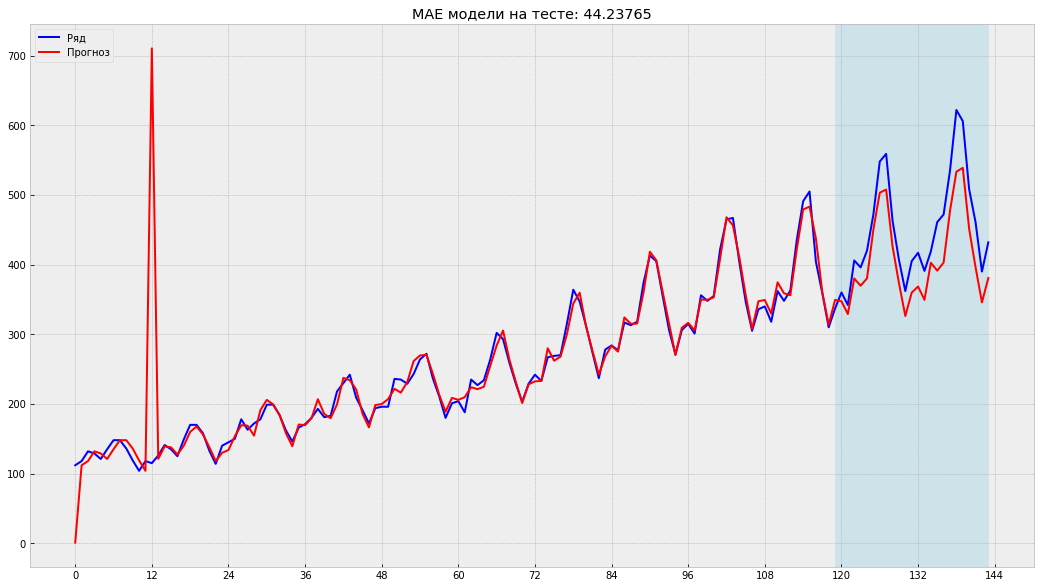

In [16]:
plot_forecast(full_ts, forecast, ts_train)

Как и следовало ожидать, фит модели на конец первого года обернулся огромным выбросом, и что-то похожее произошло с фитом на первый месяц этого же года. По части прогноза видно, что модель некорректно поймала тренд, хотя форма ряда воспроизводится весьма точно. **MAE** говорит, что модель в среднем ошибается примерно на 44 пассажира.

Теперь создадим и обучим простую рекуррентную нейронную сеть с архитектурой LSTM без каких-либо продвинутых настроек.

Для начала данные необходимо отмасштабировать и преобразовать в тензоры.

In [17]:
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_train_sc = scaler.fit_transform(ts_train.values.reshape(-1, 1))
full_ts_sc = scaler.transform(full_ts.values.reshape(-1, 1))
ts_train_nn = torch.FloatTensor(ts_train_sc).view(-1)
full_ts_nn = torch.FloatTensor(full_ts_sc).view(-1, 1)
ts_test_nn = full_ts_nn[-len(ts_test):]

Весь временной ряд необходимо преобразовать в последовательности, длина которых будет равна 12 наблюдениям (длина сезона в ряде), а таргетом при этом будет 13-е наблюдение.

In [18]:
def create_sequences(ts, tw=12):
    sequences = []
    L = len(ts)
    for i in range(L-tw):
        seq = ts[i:i+tw]
        label = ts[i+tw:i+tw+1]
        sequences.append((seq, label))
    return sequences

In [19]:
train_seqs = create_sequences(ts_train_nn)

Создаём класс собственной нейронной сети.

In [20]:
class LSTM(nn.Module):
    def __init__(self, hidden_size=64):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(1, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_size, dtype=torch.float32, device=device),
                            torch.zeros(1, 1, self.hidden_size, dtype=torch.float32, device=device))
        
    def forward(self, x):
        lstm_out, self.hidden_cell = self.lstm(x.view(len(x), 1, -1), self.hidden_cell)
        output = self.linear(lstm_out.view(len(x), -1))
        return output[-1]
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, dtype=torch.float32, device=device),
                torch.zeros(1, 1, self.hidden_size, dtype=torch.float32, device=device))

Инициализируем модель, выбираем для неё функцию потерь и алгоритм оптимизации весов.

In [21]:
model = LSTM().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Обучаем сеть и делаем предсказания.

In [22]:
num_epochs = 100
for epoch in range(num_epochs):
    for seq, label in train_seqs:
        optimizer.zero_grad()
        model.hidden_cell = model.init_hidden()
        out = model(seq.to(device))
        loss = criterion(out, label.to(device))
        loss.backward()
        optimizer.step()

In [23]:
forecast_sc = []
with torch.no_grad():
    for i in full_ts_nn:
        model.hidden_cell = model.init_hidden()
        forecast_sc.append(model(i.to(device)).item())

Модель предсказывает отмасштабированные значения, поэтому нужно сделать их обратное преобразование.

In [24]:
forecast_nn = scaler.inverse_transform(np.array(forecast_sc).reshape(-1, 1))

Теперь оценим получившуюся модель.

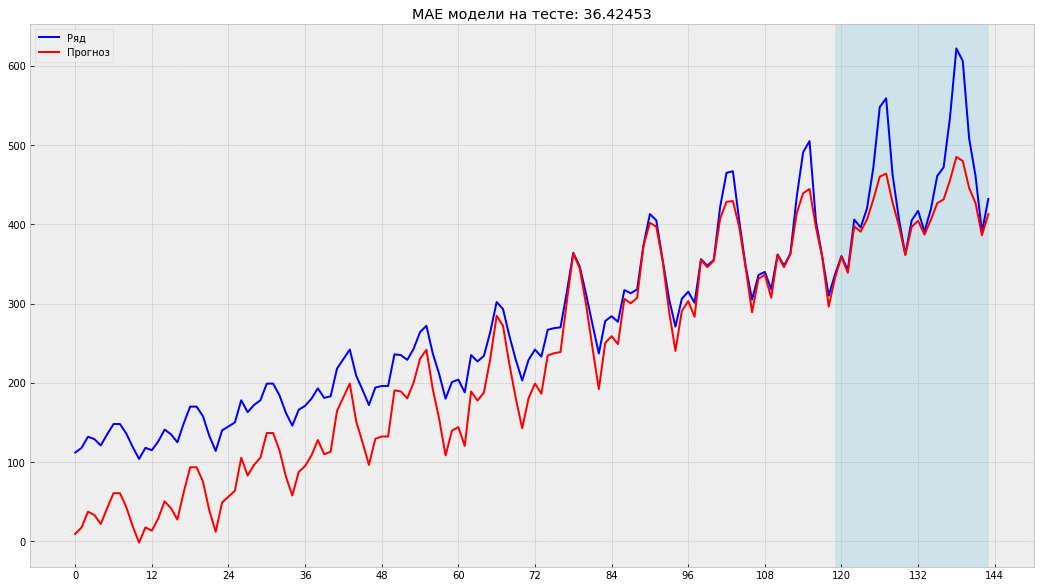

In [25]:
plot_forecast(full_ts, forecast_nn, ts_train)

Видим, что модель фитится иначе, нежели *SARIMA*, и несмотря на то, что **MAE** получилась меньше, такая нейросеть очень неустойчива, т.е. на одних и тех же данных при одних и тех же параметрах, каждый раз заново обучая сеть, фит и прогноз будут сильно отличаться. Для того, чтобы точно превзойти модель *SARIMA*, необходимы продвинутые настройки нейросети и более осмысленный подход при написании её класса, выборе функции потерь и алгоритма оптимизации.